In [ ]:
import sys
import os
import time
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import pydot
from IPython.display import SVG
from livelossplot import PlotLossesKeras

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import model_to_dot
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [ ]:
path_byte_files = "c:/Users/Moon/Malware_Classification/byte_data/"
path_dataset= 'C:/Users/Moon/Malware_Classification/malimg_paper_dataset_imgs/'
path_saved_img_dir = 'C:/Users\Moon/Malware_Classification/png_dataset/'

In [ ]:
def imageProcess(array,name):
    print('Processing '+name)
    if array.shape[1]!=16: #If not hexadecimal
        assert(False)
    b=int((array.shape[0]*16)**(0.5))
    b=2**(int(log(b)/log(2))+1)
    a=int(array.shape[0]*16/b)
    array=array[:a*b//16,:]
    array=np.reshape(array,(a,b))
    im = Image.fromarray(np.uint8(array))
    image_name = path_saved_img_dir + name + '.png'
    im.save(image_name, "PNG")
    return im

files :  ['0A32eTdBKayjCWhZqDOQ.bytes', '0ACDbR5M3ZhBJajygTuf.bytes']
Processing 0A32eTdBKayjCWhZqDOQ.bytes
Processing 0ACDbR5M3ZhBJajygTuf.bytes


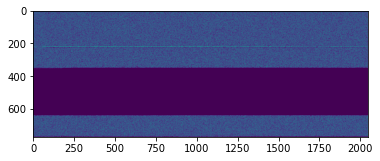

In [ ]:
#Get the list of files
files=os.listdir(path_byte_files)
print('files : ',files)
#We will process files one by one.
for counter, name in enumerate(files):
        #We only process .bytes files from our folder.
        if '.bytes' != name[-6:]:
            continue
        f=open(path_byte_files+'/'+name)
        array=[]
        for line in f:
            xx=line.split()
            if len(xx)!=17:
                continue
            array.append([int(i,16) if i!='??' else 0 for i in xx[1:] ])
        plt.imshow(imageProcess(np.array(array),name))
        del array
        f.close()

In [ ]:
def summary(X_train, y_train, X_test, y_test):
    print('Train images shape:', X_train.shape)
    print('Train labels shape:', y_train.shape)
    print('Test images shape:', X_test.shape)
    print('Test labels shape:', y_test.shape)    

In [ ]:
n_epoches = 10
image_size = (64,64)
batches = 10000
num_classes = 25
rand_seed = 40
lr=0.0001

In [ ]:
batches = ImageDataGenerator().flow_from_directory(
    directory=path_dataset, 
    target_size=image_size, 
    batch_size=batches,
    seed = rand_seed)

Found 9339 images belonging to 25 classes.


In [ ]:
imgs, labels = next(batches)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.2)

In [ ]:
summary(X_train, y_train, X_test, y_test)

Train images shape: (7471, 64, 64, 3)
Train labels shape: (7471, 25)
Test images shape: (1868, 64, 64, 3)
Test labels shape: (1868, 25)


In [ ]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(60, kernel_size=(3, 3), input_shape=(64,64,3)))
    Malware_model.add(LeakyReLU(.3))#.1
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    Malware_model.add(Conv2D(30, (3, 3)))
    Malware_model.add(LeakyReLU(.3))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    Malware_model.add(Dropout(0.25))
    
    Malware_model.add(Flatten())
    
    Malware_model.add(Dense(128))
    Malware_model.add(LeakyReLU(.1))
    Malware_model.add(Dropout(0.50))
    
    Malware_model.add(Dense(64))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    
    return Malware_model

In [ ]:
Malware_model = malware_model()

In [ ]:
Malware_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 60)        1680      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 62, 62, 60)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 30)        16230     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 29, 29, 30)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 30)       

In [ ]:
y_train_new = np.argmax(y_train, axis=1)

In [ ]:
y_train_new

array([ 3,  2,  2, ...,  3,  2, 22], dtype=int64)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_new),
                                                 y_train_new)

C:\Users\Moon\Anaconda3\envs\keras-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24], y=[ 3  2  2 ...  3  2 22] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


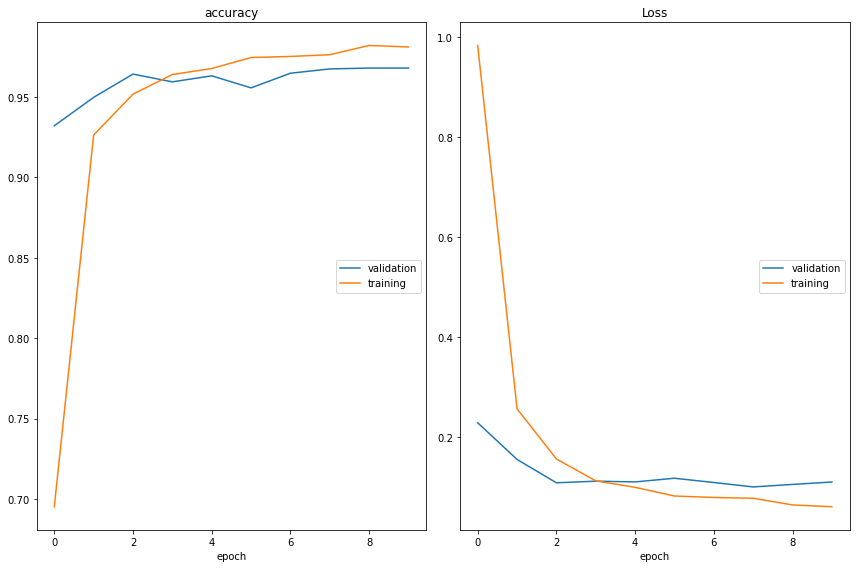

accuracy
	validation       	 (min:    0.932, max:    0.968, cur:    0.968)
	training         	 (min:    0.695, max:    0.982, cur:    0.981)
Loss
	validation       	 (min:    0.100, max:    0.229, cur:    0.110)
	training         	 (min:    0.061, max:    0.984, cur:    0.061)


In [ ]:
history = Malware_model.fit(X_train, y_train, 
                  validation_data=(X_test, y_test), 
                  epochs= n_epoches,
                  callbacks = [PlotLossesKeras()],
                  verbose=1,
                  class_weight=class_weights)

In [ ]:
evaluation = Malware_model.evaluate(X_test, y_test)

1868/1868 [==============================] - 3s 1ms/step


In [ ]:
print('Final CNN accuracy: ', evaluation[1])

Final CNN accuracy:  0.9678800702095032


In [ ]:
# import pydot
# SVG(model_to_dot(Malware_model).create(prog='dot', format='svg'))
from keras.utils.vis_utils import plot_model

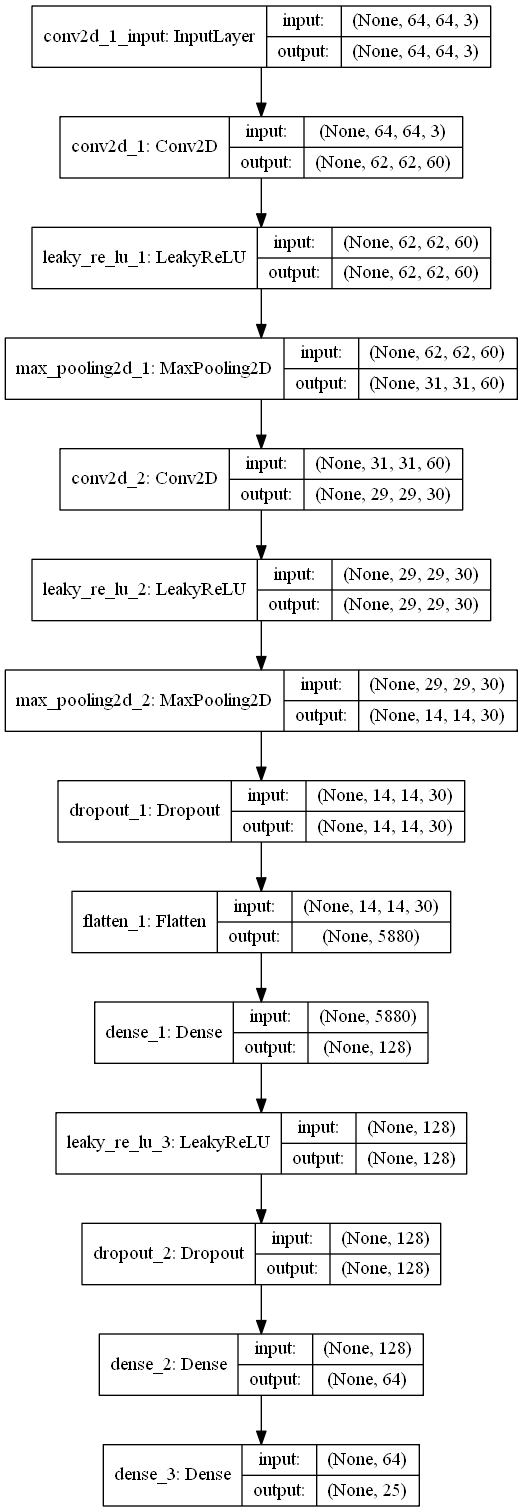

In [ ]:
plot_model(Malware_model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True, dpi=96)

In [ ]:
# es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Malware_model.fit(X_train, y_train, 
#                   validation_data=(X_test, y_test), 
#                   epochs= n_epoches,
#                   class_weight=class_weights,
#                   callbacks=[es_callback, PlotLossesKeras()])

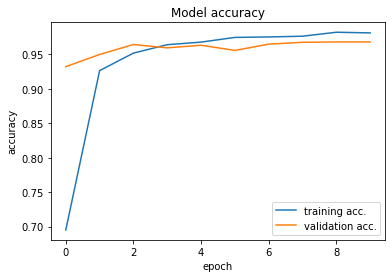

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training acc.', 'validation acc.'], loc='lower right')
plt.show()
plt.savefig('Model accuracy.png')

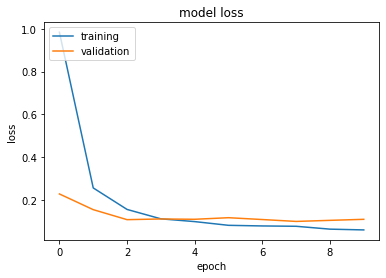

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
# import sklearn
# y_prediction = Malware_model.predict(X_test)
# confusion_matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), y_prediction.argmax(axis=1))
# confusion_matrix

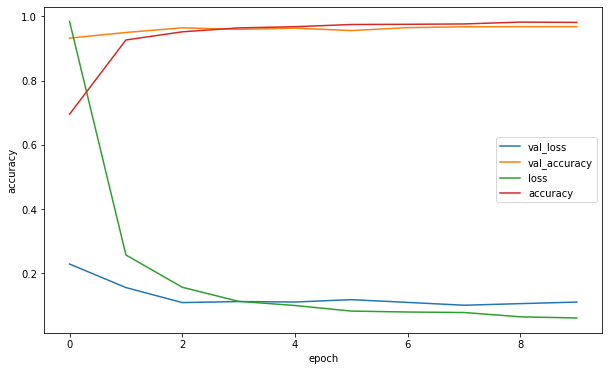

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import seaborn as sns
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
plt.savefig('img.png')

In [ ]:
start = time.clock() 
Malware_model.predict_classes(X_test, verbose=0)
end = time.clock()

print("Time per image: {} ".format((end-start)/len(X_test)))

Time per image: 0.0011967892398286842 


In [ ]:
print(end-start)

2.2356022999999823


In [ ]:
len(X_test)

1868

In [ ]:
pred_time_list=[]
for i in range(10):
    start = time.clock() 
    result=Malware_model.predict(X_test)
    end = time.clock()
    pred_time_list.append( end-start )
print(pred_time_list)

[2.311526200000003, 2.301674699999978, 2.306474699999967, 2.325368400000002, 2.3054166999999666, 2.321178100000054, 2.3042295000000195, 2.294398899999976, 2.300119699999982, 2.302853700000014]


In [ ]:
y_pred = Malware_model.predict_classes(X_test, verbose=0)

In [ ]:
y_test2 = np.argmax(y_test, axis=1)

In [ ]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [ ]:
class_names= batches.class_indices.keys()

Text(0.5, 42.0, 'Predicted label')

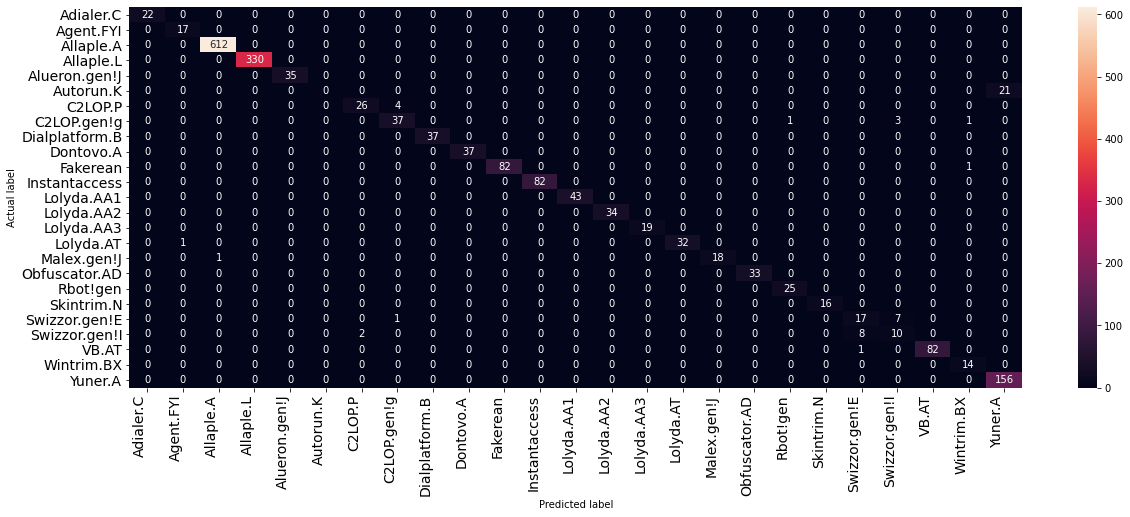

In [ ]:
df = pd.DataFrame(
        c_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(20,7))
heatmap = sns.heatmap(df, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
df

,Adialer.C,Agent.FYI,Allaple.A,Allaple.L,Alueron.gen!J,Autorun.K,C2LOP.P,C2LOP.gen!g,Dialplatform.B,Dontovo.A,...,Lolyda.AT,Malex.gen!J,Obfuscator.AD,Rbot!gen,Skintrim.N,Swizzor.gen!E,Swizzor.gen!I,VB.AT,Wintrim.BX,Yuner.A
Adialer.C,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agent.FYI,0,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Allaple.A,0,0,612,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Allaple.L,0,0,0,330,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alueron.gen!J,0,0,0,0,35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Autorun.K,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
C2LOP.P,0,0,0,0,0,0,26,4,0,0,...,0,0,0,0,0,0,0,0,0,0
C2LOP.gen!g,0,0,0,0,0,0,0,37,0,0,...,0,0,0,1,0,0,3,0,1,0
Dialplatform.B,0,0,0,0,0,0,0,0,37,0,...,0,0,0,0,0,0,0,0,0,0
Dontovo.A,0,0,0,0,0,0,0,0,0,37,...,0,0,0,0,0,0,0,0,0,0
